In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from matplotlib import cm
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from scipy.interpolate import RectBivariateSpline
from scipy.stats import kurtosis, skew
import scipy.optimize as optimize
from iminuit import Minuit

from ipywidgets import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FactorAnalysis

import sncosmo
from sncosmo.salt2utils import BicubicInterpolator

from astropy.table import Table
from tabulate import tabulate # to export in table format


%matplotlib inline

# Read the data

In [2]:
# file data paths
data_path = ".//SN_surfaces//"
file_names = glob.glob(data_path+"*.dat")
# rewrite the names
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][15:]
print("Total files in path: ", len(file_names))

Total files in path:  160


# To split the test and train dataset

In [3]:
# split our data in training and test dataset with ration 70 - 30 %
np.random.seed(42)
sn_train, sn_test = train_test_split(file_names, test_size=0.3)
print(len(sn_train), len(sn_test))

112 48


In [4]:
#Create a log file with training and testing dataset names
f = open(".//log//train_names.txt", 'w')
for i in range(0, len(sn_train)):
    f.write(str(sn_train[i][:-4])+"\n")
f.close()

f = open(".//log//test_names.txt", 'w')
for i in range(0, len(sn_test)):
    f.write(str(sn_test[i][:-4])+"\n")
f.close()

# Training the model

## Principal Component Analysis

In [5]:
TRAIN_DATASET = []
ERROR_DATASET = []

# read the training dataset
for i in range(0, len(sn_train)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_train[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TRAIN_DATASET.append(np.array(SN["flux"]))
    ERROR_DATASET.append(np.array(SN["eflux"]))

In [6]:
#rng = np.random.RandomState(42)
#sigma = 1
#SIGMAS = sigma * rng.rand(len(TRAIN_DATASET[0])) + sigma / 2.

In [7]:
def PCA_FIT(dataset, N_comp=10):
    """
    dataset: list containin spectroscopy data
    N_comp: number of components
    """
    np.random.random(42)
    # apply pca with N components
    pca = PCA(N_comp)
    pca.fit(dataset)
    return pca

In [8]:
def FA_FIT(dataset, N_comp=10):
    """
    dataset: list containin spectroscopy data
    N_comp: number of components
    """
    np.random.random(42)
    # apply pca with N components
    FA = FactorAnalysis(N_comp)
    FA.fit(dataset)
    return FA

In [9]:
N=10
pca=PCA_FIT(TRAIN_DATASET, N_comp=N)

In [10]:
N=10
FA=FA_FIT(TRAIN_DATASET + ERROR_DATASET, N_comp=N)

In [11]:
save_path = '/home/joao/Documents/GitHub/SNFACTORY_SNTRAIN/Templates/fa/'

In [12]:
for i in range(0, len(FA.components_)):
    table = []
    for n in range(0, len(SN["wave"])):
        table.append((SN["phase"][n], SN["wave"][n], FA.components_[i][n]))

    completeName = os.path.join(save_path, "M"+str(i)+".dat")

    f = open(completeName, 'w')
    f.write(tabulate(table, tablefmt="plain"))
    f.close()

In [13]:
SN["phase"]

0       -10
1        -9
2        -8
3        -7
4        -6
         ..
30556    46
30557    47
30558    48
30559    49
30560    50
Name: phase, Length: 30561, dtype: int64

In [14]:
len(FA.components_)

10

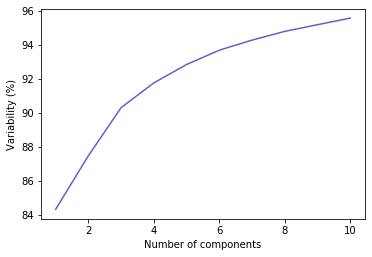

In [15]:
plt.plot(np.linspace(1, 10, 10, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('Number of components')
plt.ylabel('Variability (%)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

#plt.savefig("/home/joao/Desktop/variabilidade_acumulada.png", dpi = 200)   # save the figure to file

In [16]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.9031274070020153


In [17]:
# grid plot
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8000, 451)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

### Mean surface

/home/joao/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


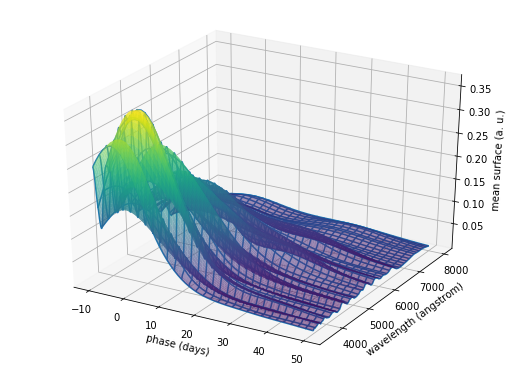

In [18]:
#matplotlib notebook

Z = interp.griddata((SN["phase"],SN["wave"]),pca.mean_,(B1,B2),method='cubic')
#Z = splinemean(B1, B2)
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("wavelength (angstrom)")
ax.set_zlabel("mean surface (a. u.)")

plt.show()

### Components

In [19]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

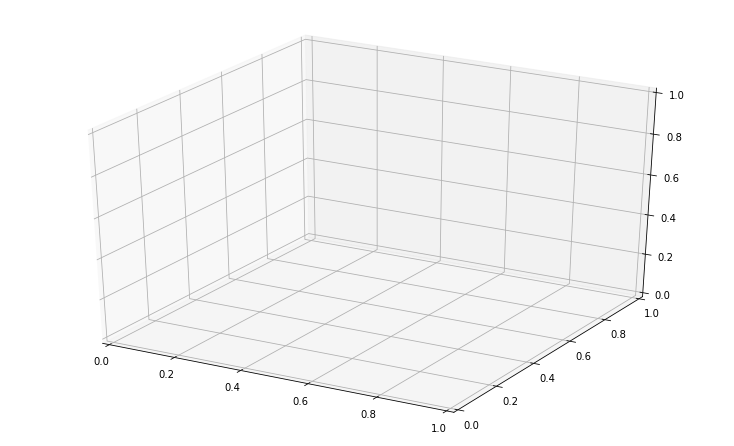

In [20]:
#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()

    Z = interp.griddata((SN["phase"],SN["wave"]),-pca.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("wavelength (angstrom)")
    ax.set_zlabel("components (a. u.)")


    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

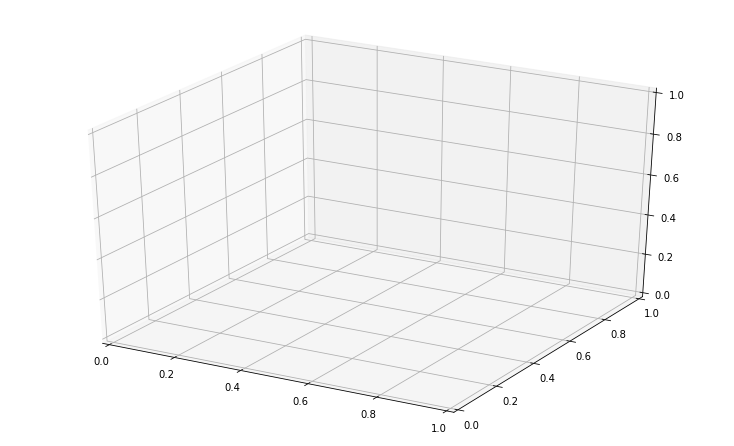

In [21]:
#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()

    Z = interp.griddata((SN["phase"],SN["wave"]),FA.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("wavelength (angstrom)")
    ax.set_zlabel("components (a. u.)")


    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [22]:
# training grid
TEMP_PHASE_GRID = np.linspace(-10, 50, 61, dtype=int)
TEMP_WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [23]:
# 2d grid
X_GRID = []
Y_GRID = []
for i in range(0, len(TEMP_PHASE_GRID)):
    for j in range(0, len(TEMP_WAVE_GRID)):
        X_GRID.append(TEMP_PHASE_GRID[i])
        Y_GRID.append(TEMP_WAVE_GRID[j])

In [24]:
# Templates dataset in a pandas dataframe
templates = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), -(pca.components_[i].reshape(501, 61).T).reshape(1, len(pca.components_[i]))[0]] # to save as a pandas dataframe
    templates.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates))

number of templates generated:  10


In [25]:
# Templates dataset in a pandas dataframe
templates_FA = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), (FA.components_[i].reshape(501, 61).T).reshape(1, len(FA.components_[i]))[0]] # to save as a pandas dataframe
    templates_FA.append(-pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates_FA))

number of templates generated:  10


## Mean, Standard Deviation and Skewness

In [26]:
# Mean, Standard Deviation and Skewness surfaces
MEAN = np.mean(TRAIN_DATASET, axis=0)
DESVP = np.std(TRAIN_DATASET, axis=0)
SKW = skew(TRAIN_DATASET, axis=0)

STATISTICAL_MOMENTS = [MEAN, DESVP, SKW]

In [27]:
# Given templates in a pandas dataframe
ST_MOM = []
for i in range(3):
    data = [np.array(X_GRID), np.array(Y_GRID), (STATISTICAL_MOMENTS[i].reshape(501, 61).T).reshape(1, len(STATISTICAL_MOMENTS[i]))[0]] # to save as a pandas dataframe
    ST_MOM.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(ST_MOM))

number of templates generated:  3


# Generate photometry data

In [28]:
# csp filters using sncosmo
ab = sncosmo.get_magsystem('ab')
# catalog of bands
csp_filtersname = ["cspg", "cspr", "cspv9844"]
csp_filters = [sncosmo.get_bandpass('cspg'), sncosmo.get_bandpass('cspr'), sncosmo.get_bandpass('cspv9844')]

In [29]:
# photometry grid
PHOTO_XGRID = np.linspace(-10, 45, 16, dtype=int)
WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [30]:
def function_gen(data, dwave=10, returnfun="on"):
    """
    data: pandas dataframe structured with column names as phase, wave and flux
    dwave: differencial wavelength (defaut 10 angstroms)
    returnfun: variable to define what you will want to return. If on it return function, if off return data values
    """
    
    if returnfun == "on":
        functions = []
        for nn in range(0, len(csp_filters)): # run over filters
            temp_flux = []
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # integral element
                temp_flux.append(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))
            functions.append(Spline1d(PHOTO_XGRID, temp_flux)) # save each function to return (number of functions will be the number of filters)
        return functions

    if returnfun == "off":
        
        temp_phase =[]
        temp_flux = []
        temp_eflux = []
        temp_filter = []
        temp_zp = []
        temp_zpsys = []
        for nn in range(0, len(csp_filters)): # run over filters
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # lists to transform in a pandas dataframe (format of sncosmo fit)
                temp_phase.append(float(PHOTO_XGRID[ii]))
                temp_flux.append(float(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))) # flux
                temp_eflux.append(float(np.sum(csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave*data[data["phase"]==PHOTO_XGRID[ii]]["eflux"]))) # error on flux
                temp_filter.append(str(csp_filtersname[nn])) # given bands
                temp_zp.append(2.5*np.log10(ab.zpbandflux(csp_filtersname[nn]))) # zeropoint magnitudes
                temp_zpsys.append("ab") # magnitude format
                temp_data = [temp_phase, temp_flux, temp_eflux, temp_filter, temp_zp, temp_zpsys] # to save as a pandas dataframe
                temp_data = pd.DataFrame(np.array(temp_data).T, columns=["time", "flux", "fluxerr", "band", "zp", "zpsys"]) # collumn names in agreement with sncosmo
        return temp_data

In [31]:
# Filters dictionary
'''
M0_filt = dict({'cspg':function_gen(templates[0])[0],
                'cspr':function_gen(templates[0])[1],
                'cspv9844':function_gen(templates[0])[2]})

M1_filt = dict({'cspg':function_gen(templates[1])[0],
                'cspr':function_gen(templates[1])[1],
                'cspv9844':function_gen(templates[1])[2]})

M2_filt = dict({'cspg':function_gen(templates[2])[0],
                'cspr':function_gen(templates[2])[1],
                'cspv9844':function_gen(templates[2])[2]})

M3_filt = dict({'cspg':function_gen(templates[3])[0],
                'cspr':function_gen(templates[3])[1],
                'cspv9844':function_gen(templates[3])[2]})

M4_filt = dict({'cspg':function_gen(templates[4])[0],
                'cspr':function_gen(templates[4])[1],
                'cspv9844':function_gen(templates[4])[2]})

M5_filt = dict({'cspg':function_gen(templates[5])[0],
                'cspr':function_gen(templates[5])[1],
                'cspv9844':function_gen(templates[5])[2]})

M6_filt = dict({'cspg':function_gen(templates[6])[0],
                'cspr':function_gen(templates[6])[1],
                'cspv9844':function_gen(templates[6])[2]})

M7_filt = dict({'cspg':function_gen(templates[7])[0],
                'cspr':function_gen(templates[7])[1],
                'cspv9844':function_gen(templates[7])[2]})

M8_filt = dict({'cspg':function_gen(templates[8])[0],
                'cspr':function_gen(templates[8])[1],
                'cspv9844':function_gen(templates[8])[2]})

M9_filt = dict({'cspg':function_gen(templates[9])[0],
                'cspr':function_gen(templates[9])[1],
                'cspv9844':function_gen(templates[9])[2]})
'''

"\nM0_filt = dict({'cspg':function_gen(templates[0])[0],\n                'cspr':function_gen(templates[0])[1],\n                'cspv9844':function_gen(templates[0])[2]})\n\nM1_filt = dict({'cspg':function_gen(templates[1])[0],\n                'cspr':function_gen(templates[1])[1],\n                'cspv9844':function_gen(templates[1])[2]})\n\nM2_filt = dict({'cspg':function_gen(templates[2])[0],\n                'cspr':function_gen(templates[2])[1],\n                'cspv9844':function_gen(templates[2])[2]})\n\nM3_filt = dict({'cspg':function_gen(templates[3])[0],\n                'cspr':function_gen(templates[3])[1],\n                'cspv9844':function_gen(templates[3])[2]})\n\nM4_filt = dict({'cspg':function_gen(templates[4])[0],\n                'cspr':function_gen(templates[4])[1],\n                'cspv9844':function_gen(templates[4])[2]})\n\nM5_filt = dict({'cspg':function_gen(templates[5])[0],\n                'cspr':function_gen(templates[5])[1],\n                'cspv9844':

# Generating Sintetic fotometry on test data

In [32]:
TEST_DATASET=[]
# use the function above
for i in range(0, len(sn_test)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_test[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TEST_DATASET.append(SN)

In [33]:
# photometry data
PHOTOMETRY_DATASET_TEST = []
for i in range(0, len(TEST_DATASET)):
    PHOTOMETRY_DATASET_TEST.append(Table(data=Table.from_pandas(function_gen(TEST_DATASET[i], returnfun="off")), dtype=[float, float, float, str, float, str]))

# Models Fit

### SALT2

In [34]:
def salt2_fit(data):
    # create a model
    model = sncosmo.Model(source='salt2') # sncosmo model (salt2)
    model.set(z=0, t0=0, c=0) # fixed params
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model, ['x0', 'x1'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (SALT2): ", result.chisq/result.ndof)
    
    #sncosmo.plot_lc(data, model=fitted_model, errors=result.errors);
    return fitted_model, result

### Single Expansion Model (Using PCA) (com todas 10 componentes)

In [35]:
#from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  


        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)

# Light Curve Fits

In [36]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

# templates reshaped
M0_reshape = np.array(templates[0]["flux"]).reshape(61, 501) 
M1_reshape = np.array(templates[1]["flux"]).reshape(61, 501)
M2_reshape = np.array(templates[2]["flux"]).reshape(61, 501)
M3_reshape = np.array(templates[3]["flux"]).reshape(61, 501)
M4_reshape = np.array(templates[4]["flux"]).reshape(61, 501)
M5_reshape = np.array(templates[5]["flux"]).reshape(61, 501)
M6_reshape = np.array(templates[6]["flux"]).reshape(61, 501)
M7_reshape = np.array(templates[7]["flux"]).reshape(61, 501)
M8_reshape = np.array(templates[8]["flux"]).reshape(61, 501)
M9_reshape = np.array(templates[9]["flux"]).reshape(61, 501)
c = pd.read_csv(".//Templates//salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

In [37]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

# templates reshaped
M0_reshape_FA = np.array(templates_FA[0]["flux"]).reshape(61, 501) 
M1_reshape_FA = np.array(templates_FA[1]["flux"]).reshape(61, 501)
M2_reshape_FA = np.array(templates_FA[2]["flux"]).reshape(61, 501)
M3_reshape_FA = np.array(templates_FA[3]["flux"]).reshape(61, 501)
M4_reshape_FA = np.array(templates_FA[4]["flux"]).reshape(61, 501)
M5_reshape_FA = np.array(templates_FA[5]["flux"]).reshape(61, 501)
M6_reshape_FA = np.array(templates_FA[6]["flux"]).reshape(61, 501)
M7_reshape_FA = np.array(templates_FA[7]["flux"]).reshape(61, 501)
M8_reshape_FA = np.array(templates_FA[8]["flux"]).reshape(61, 501)
M9_reshape_FA = np.array(templates_FA[9]["flux"]).reshape(61, 501)

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

## SALT2 x EXP(3)

In [38]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [39]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2 (c=0)", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## EXP3(PCA) x EXP3(FA)

In [40]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape_FA, M1_reshape_FA, M2_reshape_FA, M3_reshape_FA, M4_reshape_FA, M5_reshape_FA, M6_reshape_FA, M7_reshape_FA, M8_reshape_FA, M9_reshape_FA, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP) FA: ", result_exp.chisq/result_exp.ndof)
    
    
    exp_pca = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model_pca = sncosmo.Model(source=exp_pca)

    model_pca.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp_pca, model_exp_pca = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model_pca, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP) PCA: ", result_exp_pca.chisq/result_exp_pca.ndof)
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp, model_exp_pca],
                    errors=[result_exp.errors, result_exp_pca.errors],
                    model_label=["EXP(3) FA", "EXP(3) PCA"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP4

In [41]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP10

In [42]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## EXP(3)x EXP10

In [43]:
def update_graph(i):
    
    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)
    
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3, model_exp10],
                    errors=[result_exp3.errors, result_exp10.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

### SALT2 x EXP(3) with LC (x0, x1, x2, c)

In [44]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [45]:
def free_parameters(ii):
    """
    i:SN train index
    """
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    
    return result_exp.parameters[2], result_exp.parameters[3], result_exp.parameters[4], result_salt2.parameters[2], result_salt2.parameters[3], result_salt2.parameters[4]

In [36]:
df = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 6)), columns=["x0_exp", "x1_exp", "x2_exp", "x0_salt2", "x1_salt2", "c_salt2"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_salt2, x1_salt2, c_salt2 = free_parameters(i)
    df["x0_exp"][i] = -2.5*np.log10(x0_exp)
    df["x1_exp"][i] = x1_exp
    df["x2_exp"][i] = x2_exp
    df["x0_salt2"][i] = -2.5*np.log10(x0_salt2)
    df["x1_salt2"][i] = x1_salt2
    df["c_salt2"][i] = c_salt2

df.head()

/tmp/ipykernel_27559/1797058000.py:4: RuntimeWarning: invalid value encountered in log10
  df["x0_exp"][i] = -2.5*np.log10(x0_exp)


,x0_exp,x1_exp,x2_exp,x0_salt2,x1_salt2,c_salt2
0,NaN,0.461973,-0.575618,-10.182429,-1.941286,0.0
1,28.764108,-140808.302077,278061.684072,-10.521916,-0.134080,0.0
2,NaN,0.280235,-0.215200,-10.242802,-0.566359,0.0
3,26.673514,-19589.070459,37863.645958,-10.467690,0.055918,0.0
4,NaN,0.351491,-0.283313,-10.270304,-1.598777,0.0


In [37]:
salt2_param_names = {
    0:"x0_salt2",
    1:"x1_salt2",
    2:"c_salt2"
}

salt2_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$c$"
}

exp_param_names = {
    0:"x0_exp",
    1:"x1_exp",
    2:"x2_exp"
}

exp_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/joao/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/joao/.local/lib/python3.8/site

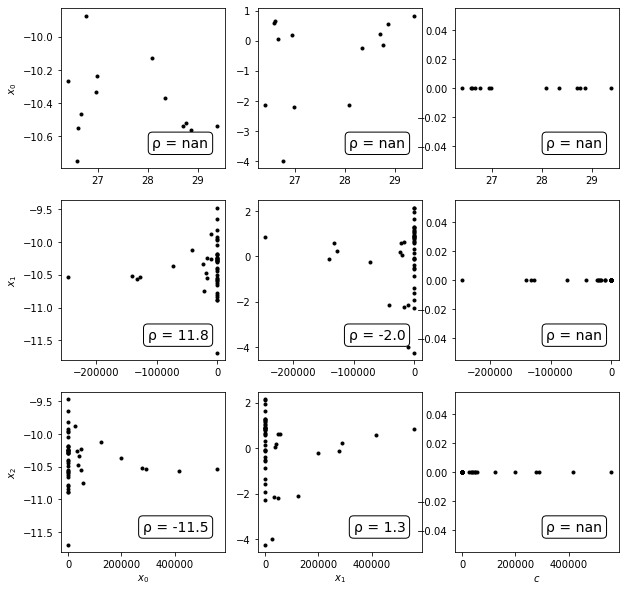

In [38]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        ax[i, j].plot(df[exp_param_names[i]], df[salt2_param_names[j]], 'k.', label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(df[exp_param_names[i]], df[salt2_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp_param_latex[i])
        if i == 2:
            ax[i, j].set_xlabel(salt2_param_latex[j])

## SALT2 x SNEMO2 (with c=0)

In [39]:
#SNEMO2 = pd.read_csv("/home/joao/Documents/Research/SNFACTORY_SNTRAIN/Templates/snemo2/snemo2_ev.dat",
SNEMO2 = pd.read_csv("./Templates/snemo2/snemo2_ev.dat",
                       sep="\s+",
                       names=["time", "wave", "M0", "M1"])
SNEMO2.head()

,time,wave,M0,M1
0,-20.0,3305.0,0.0,0.0
1,-20.0,3317.0,0.0,0.0
2,-20.0,3328.0,0.0,0.0
3,-20.0,3339.0,0.0,0.0
4,-20.0,3350.0,0.0,0.0


In [40]:
SNEMO2["time"].unique()

array([-20., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,
        10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  60.])

In [41]:
gridx_SNEMO = SNEMO2["time"].unique()
gridy_SNEMO= SNEMO2["wave"].unique()

M0_SNEMO2_reshape = np.array(SNEMO2["M0"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))
M1_SNEMO2_reshape = np.array(SNEMO2["M1"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))

In [47]:
def update_graph(i):
    
    exp = EXP_LC(gridx_SNEMO, gridy_SNEMO, M0_SNEMO2_reshape, M1_SNEMO2_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x2=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "SNEMO"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

# Finding corrrelations between EXP(3) x EXP10 model coefficients 

In [43]:
def parametros_ajustes(ii):
    """
    i:SN train index
    """   
    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)

    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    
        
    model3 = sncosmo.Model(source=exp3)
    model10 = sncosmo.Model(source=exp10)

    model3.set(z=0., t0=0)
    model10.set(z=0., t0=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2'], modelcov=False)
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)

    return result_exp3.parameters[2], result_exp3.parameters[3], result_exp3.parameters[4], result_exp10.parameters[2], result_exp10.parameters[3], result_exp10.parameters[4], result_exp10.parameters[5], result_exp10.parameters[6], result_exp10.parameters[7], result_exp10.parameters[8], result_exp10.parameters[9], result_exp10.parameters[10], result_exp10.parameters[11]

In [44]:
param_ajuste = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 13)), columns=["x0_exp3", "x1_exp3", "x2_exp3", "x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_exp10, x1_exp10, x2_exp10, x3_exp10, x4_exp10, x5_exp10, x6_exp10, x7_exp10, x8_exp10, x9_exp10  = parametros_ajustes(i)
    #param_ajuste["x0_exp3"][i] = -2.5*np.log10(x0_exp)
    param_ajuste["x0_exp3"][i] = x0_exp
    param_ajuste["x1_exp3"][i] = x1_exp
    param_ajuste["x2_exp3"][i] = x2_exp
    #param_ajuste["x0_exp10"][i] = -2.5*np.log10(x0_exp10)
    param_ajuste["x0_exp10"][i] = x0_exp10
    param_ajuste["x1_exp10"][i] = x1_exp10
    param_ajuste["x2_exp10"][i] = x2_exp10
    param_ajuste["x3_exp10"][i] = x3_exp10
    param_ajuste["x4_exp10"][i] = x4_exp10
    param_ajuste["x5_exp10"][i] = x5_exp10
    param_ajuste["x6_exp10"][i] = x6_exp10
    param_ajuste["x7_exp10"][i] = x7_exp10
    param_ajuste["x8_exp10"][i] = x8_exp10
    param_ajuste["x9_exp10"][i] = x9_exp10

param_ajuste.head()

KeyboardInterrupt: 

In [ ]:
exp3_param_names = {
    0:"x0_exp3",
    1:"x1_exp3",
    2:"x2_exp3"
}

exp3_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}
exp10_param_names = {
    0:"x0_exp10",
    1:"x1_exp10",
    2:"x2_exp10",
    3:"x3_exp10",
    4:"x4_exp10",
    5:"x5_exp10",
    6:"x6_exp10",
    7:"x7_exp10",
    8:"x8_exp10",
    9:"x9_exp10"
}

exp10_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$",
    3:"$x_3$",
    4:"$x_4$",
    5:"$x_5$",
    6:"$x_6$",
    7:"$x_7$",
    8:"$x_8$",
    9:"$x_9$"
}

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,36))
for i in range(10):
    for j in range(3):
        ax[i, j].plot(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]], 'k.')#, label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp10_param_latex[i])
        if i == 9:
            ax[i, j].set_xlabel(exp3_param_latex[j])
plt.savefig('correlation.pdf')

In [ ]:
correlation_matrix=pd.DataFrame(data=np.zeros(shape=(10, 3)), index=["x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"],columns=["x0_exp3","x1_exp3","x2_exp3"])
for i in range(10):
    for j in range(3):
        correlation_matrix[exp3_param_names[j]][exp10_param_names[i]]=round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1], 4)

In [ ]:
correlation_matrix

In [ ]:
new_M0=np.zeros(shape=M0_reshape.shape)
new_M1=np.zeros(shape=M1_reshape.shape)
new_M2=np.zeros(shape=M2_reshape.shape)
M=[M0_reshape,M1_reshape,M2_reshape,M3_reshape,M4_reshape,M5_reshape,M6_reshape,M7_reshape,M8_reshape,M9_reshape]
for i in range(10):
    new_M0+=M[i]*correlation_matrix["x0_exp3"][exp10_param_names[i]]
    new_M1+=M[i]*correlation_matrix["x1_exp3"][exp10_param_names[i]]
    new_M2+=M[i]*correlation_matrix["x2_exp3"][exp10_param_names[i]]

## SALT2 x New EXP(3)

In [ ]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

## New EXP(3) x EXP10

In [ ]:
def update_graph(i):
    
    exp3 = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)
    
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3, model_exp10],
                    errors=[result_exp3.errors, result_exp10.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

## New EXP(3) x Old EXP(3)

In [ ]:
def update_graph(i):
    
    exp3_new = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3_new = sncosmo.Model(source=exp3_new)

    model3_new.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3_new, model_exp3_new = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3_new, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3_new, model_exp3],
                    errors=[result_exp3_new.errors, result_exp3.errors],
                    model_label=["New EXP(3)", "Old EXP3"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

In [ ]:
new_M0-M0_reshape

## Variance convergency

In [ ]:
len(TRAIN_DATASET)

In [ ]:
N_COMPONENTS = np.linspace(10, 112, 50, dtype=int)

In [ ]:
N_training = []
for i in range(0, len(N_COMPONENTS)):
    N_training.append(np.array(random.sample(range(0,112), N_COMPONENTS[i])))

In [ ]:
variances = []
templates = []

In [ ]:
for i in range(0, len(N_COMPONENTS)):
    new_dataset = []
    for j in range(0, len(N_training[i])):
        for k in range(0, len(TRAIN_DATASET)):
            if k==int(N_training[i][j]):
                new_dataset.append(np.array(TRAIN_DATASET[k]))
                
    temporary_pca=PCA_FIT(new_dataset, N_comp=10)
    variances.append(temporary_pca.explained_variance_ratio_[0]+temporary_pca.explained_variance_ratio_[1]+temporary_pca.explained_variance_ratio_[2])
    templates.append([temporary_pca.components_[0], temporary_pca.components_[1], temporary_pca.components_[2], temporary_pca.components_[3], temporary_pca.components_[4], temporary_pca.components_[5], temporary_pca.components_[6], temporary_pca.components_[7], temporary_pca.components_[8], temporary_pca.components_[9]])

In [ ]:
plt.plot(N_COMPONENTS, variances, 'k-')
plt.xlabel("# of training data")
plt.ylabel("variance %");

In [ ]:
for i in range(0, len(templates)):
    for j in range(0, len(templates[i])):
        templates[i][j] = (templates[i][j].reshape(501, 61).T).reshape(1, len(templates[i][j]))

In [ ]:
mean_chisq = []
for i in range(0, len(templates)):
    print("-----------------", i, "-----------------")
    chisq = []
    for j in range(0, len(PHOTOMETRY_DATASET_TEST)):
        
        comp0_reshape = np.array(templates[i][0]).reshape(61, 501) 
        comp1_reshape = np.array(templates[i][1]).reshape(61, 501)
        comp2_reshape = np.array(templates[i][2]).reshape(61, 501)
        comp3_reshape = np.array(templates[i][3]).reshape(61, 501)
        comp4_reshape = np.array(templates[i][4]).reshape(61, 501)
        comp5_reshape = np.array(templates[i][5]).reshape(61, 501)
        comp6_reshape = np.array(templates[i][6]).reshape(61, 501)
        comp7_reshape = np.array(templates[i][7]).reshape(61, 501)
        comp8_reshape = np.array(templates[i][8]).reshape(61, 501)
        comp9_reshape = np.array(templates[i][9]).reshape(61, 501)

        exp = EXP_LC(gridx, gridy, comp0_reshape, comp1_reshape, comp2_reshape, comp3_reshape, comp4_reshape, comp5_reshape, comp6_reshape, comp7_reshape, comp8_reshape, comp9_reshape, c, name='EXP')
        model = sncosmo.Model(source=exp)

        model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)

        result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[j], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
        if result_exp.chisq/result_exp.ndof < 10:
            print(result_exp.chisq/result_exp.ndof)
            chisq.append(result_exp.chisq/result_exp.ndof)   
    mean_chisq.append(np.mean(chisq))

In [ ]:
mean_chisq

In [ ]:
plt.plot(N_COMPONENTS, mean_chisq, 'k-')
plt.xlabel("chi²/dof")
plt.ylabel("variance %");